In [1]:
import sys
from comet_ml import Experiment
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchinfo import summary

# Local imports
sys.path.append("/Users/leo/Programming/Thesis/utils")
sys.path.append("/Users/leo/Programming/Thesis/models")

from helper_functions import (delete_ds_store,plot_metrics,test,train,mean_std_finder,load_model)
from GhostNet import ghost_net
from config import comet_token, project_name, workspace
from torchvision.models import (mobilenet_v3_small, MobileNet_V3_Small_Weights as weights_small)

# Setting the seed for reproducibility
torch.manual_seed(42)

In [2]:
prms = {
    "backbone": mobilenet_v3_small,
    "weights": None,
    "module": "ghost",
    "module_alias": "GhostNet",
    "data_path": "/Users/leo/Programming/Thesis/data/vgg_200/",
    "batch_size": 32,
    "img_size": 224,
    "num_classes": 200,
    "epochs": 50,
    "learning_rate": 0.001,
    "device": "mps",
    "model": None,
    "experiment": Experiment(api_key=comet_token, project_name=project_name, workspace=workspace, log_code=True),
    "load_model": False,
}
prms["model_save_path"] = f"./saved_weights/{prms['module_alias']}_{prms['data_path'].split('/')[-2]}.pth"

model = prms["model"] = ghost_net(num_classes=prms["num_classes"], module_type = prms["module"])
delete_ds_store(prms["data_path"])

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/leothesouthafrican/vgg-200/038a6b9db3e34a0999d13c4fb3637a4c



In [3]:
#mean, std = mean_std_finder(prms["data_path"])
mean, std = torch.tensor([0.5235, 0.4358, 0.3905]), torch.tensor([0.2993, 0.2770, 0.2729])

train_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [4]:
#Accessing the data
train_data = torchvision.datasets.ImageFolder(prms["data_path"] + "train/", transform=train_transform)
val_data = torchvision.datasets.ImageFolder(prms["data_path"] + "val/", transform=test_transform)
test_data = torchvision.datasets.ImageFolder(prms["data_path"] + "test/", transform=test_transform)

#Creating the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=prms["batch_size"], shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=prms["batch_size"], shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=prms["batch_size"], shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


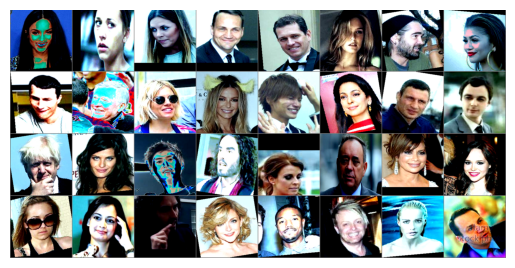

In [5]:
#display random images from the dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #drop axis labels
    plt.axis('off')
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [6]:
#build the model
model = prms["model"].to(prms["device"])

# Loss and optimizer
criterion = nn.CrossEntropyLoss().to(prms["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=prms["learning_rate"])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

prms["experiment"].log_parameters({"loss": criterion, "optimizer": optimizer}) if prms["experiment"] else None

In [7]:
summary(model, input_size=(1, 3, prms["img_size"], prms["img_size"]),
        col_names = ["input_size", "output_size", "num_params", "kernel_size", "mult_adds", "trainable"],
        col_width = 20,
        row_settings = ["var_names"],
        depth=8)

/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),


Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Kernel Shape         Mult-Adds            Trainable
GhostNet (GhostNet)                                     [1, 3, 224, 224]     [1, 200]             --                   --                   --                   True
├─Sequential (features)                                 [1, 3, 224, 224]     [1, 96, 7, 7]        --                   --                   --                   True
│    └─Sequential (0)                                   [1, 3, 224, 224]     [1, 16, 112, 112]    --                   --                   --                   True
│    │    └─Conv2d (0)                                  [1, 3, 224, 224]     [1, 16, 112, 112]    432                  [3, 3]               5,419,008            True
│    │    └─BatchNorm2d (1)                             [1, 16, 112, 112]    [1, 16, 112, 112]    32                   --                   32                   True

100%|██████████| 343/343 [00:33<00:00, 10.12it/s]


Epoch: 01 | Epoch Time: 11.0m 44s
	Train Loss: 4.870 | Train Acc: 3.48%
	 Val. Loss: 4.054 |  Val. Acc: 9.47%
Best Accuracy Achieved: 9.47% on epoch 01


100%|██████████| 343/343 [00:30<00:00, 11.21it/s]


Epoch: 02 | Epoch Time: 11.0m 26s
	Train Loss: 3.933 | Train Acc: 11.79%
	 Val. Loss: 3.381 |  Val. Acc: 19.95%
Best Accuracy Achieved: 19.95% on epoch 02


100%|██████████| 343/343 [00:30<00:00, 11.33it/s]


Epoch: 03 | Epoch Time: 11.0m 30s
	Train Loss: 3.270 | Train Acc: 22.96%
	 Val. Loss: 2.810 |  Val. Acc: 31.44%
Best Accuracy Achieved: 31.44% on epoch 03


100%|██████████| 343/343 [00:31<00:00, 10.92it/s]


Epoch: 04 | Epoch Time: 11.0m 24s
	Train Loss: 2.728 | Train Acc: 33.53%
	 Val. Loss: 2.293 |  Val. Acc: 42.70%
Best Accuracy Achieved: 42.70% on epoch 04


100%|██████████| 343/343 [00:31<00:00, 11.04it/s]


Epoch: 05 | Epoch Time: 11.0m 41s
	Train Loss: 2.315 | Train Acc: 42.11%
	 Val. Loss: 2.020 |  Val. Acc: 49.46%
Best Accuracy Achieved: 49.46% on epoch 05


100%|██████████| 343/343 [00:30<00:00, 11.12it/s]


Epoch: 06 | Epoch Time: 11.0m 25s
	Train Loss: 2.015 | Train Acc: 48.78%
	 Val. Loss: 1.813 |  Val. Acc: 54.36%
Best Accuracy Achieved: 54.36% on epoch 06


100%|██████████| 343/343 [00:31<00:00, 10.91it/s]


Epoch: 07 | Epoch Time: 11.0m 33s
	Train Loss: 1.776 | Train Acc: 54.29%
	 Val. Loss: 1.640 |  Val. Acc: 58.82%
Best Accuracy Achieved: 58.82% on epoch 07


100%|██████████| 343/343 [00:29<00:00, 11.48it/s]


Epoch: 08 | Epoch Time: 11.0m 26s
	Train Loss: 1.588 | Train Acc: 58.46%
	 Val. Loss: 1.486 |  Val. Acc: 62.26%
Best Accuracy Achieved: 62.26% on epoch 08


100%|██████████| 343/343 [00:29<00:00, 11.53it/s]


Epoch: 09 | Epoch Time: 11.0m 18s
	Train Loss: 1.421 | Train Acc: 62.59%
	 Val. Loss: 1.358 |  Val. Acc: 65.57%
Best Accuracy Achieved: 65.57% on epoch 09


100%|██████████| 343/343 [00:33<00:00, 10.16it/s]


Epoch: 10 | Epoch Time: 11.0m 29s
	Train Loss: 1.293 | Train Acc: 65.42%
	 Val. Loss: 1.388 |  Val. Acc: 65.17%


100%|██████████| 343/343 [00:30<00:00, 11.30it/s]


Epoch: 11 | Epoch Time: 10.0m 58s
	Train Loss: 1.172 | Train Acc: 68.52%
	 Val. Loss: 1.339 |  Val. Acc: 66.24%
Best Accuracy Achieved: 66.24% on epoch 11


100%|██████████| 343/343 [00:31<00:00, 10.84it/s]


Epoch: 12 | Epoch Time: 11.0m 26s
	Train Loss: 1.079 | Train Acc: 70.70%
	 Val. Loss: 1.271 |  Val. Acc: 69.00%
Best Accuracy Achieved: 69.00% on epoch 12


100%|██████████| 343/343 [00:28<00:00, 11.84it/s]


Epoch: 13 | Epoch Time: 11.0m 4s
	Train Loss: 0.991 | Train Acc: 72.80%
	 Val. Loss: 1.202 |  Val. Acc: 69.88%
Best Accuracy Achieved: 69.88% on epoch 13


100%|██████████| 343/343 [00:31<00:00, 10.97it/s]


Epoch: 14 | Epoch Time: 11.0m 7s
	Train Loss: 0.923 | Train Acc: 74.60%
	 Val. Loss: 1.203 |  Val. Acc: 70.55%
Best Accuracy Achieved: 70.55% on epoch 14


100%|██████████| 343/343 [00:30<00:00, 11.20it/s]


Epoch: 15 | Epoch Time: 11.0m 6s
	Train Loss: 0.855 | Train Acc: 76.17%
	 Val. Loss: 1.168 |  Val. Acc: 71.63%
Best Accuracy Achieved: 71.63% on epoch 15


100%|██████████| 343/343 [00:31<00:00, 11.06it/s]


Epoch: 16 | Epoch Time: 11.0m 13s
	Train Loss: 0.796 | Train Acc: 77.67%
	 Val. Loss: 1.147 |  Val. Acc: 71.79%
Best Accuracy Achieved: 71.79% on epoch 16


100%|██████████| 343/343 [00:30<00:00, 11.30it/s]


Epoch: 17 | Epoch Time: 11.0m 11s
	Train Loss: 0.746 | Train Acc: 78.89%
	 Val. Loss: 1.250 |  Val. Acc: 71.34%


100%|██████████| 343/343 [00:30<00:00, 11.32it/s]


Epoch: 18 | Epoch Time: 11.0m 10s
	Train Loss: 0.700 | Train Acc: 80.11%
	 Val. Loss: 1.129 |  Val. Acc: 72.74%
Best Accuracy Achieved: 72.74% on epoch 18


100%|██████████| 343/343 [00:30<00:00, 11.23it/s]


Epoch: 19 | Epoch Time: 11.0m 9s
	Train Loss: 0.655 | Train Acc: 81.18%
	 Val. Loss: 1.195 |  Val. Acc: 72.34%


100%|██████████| 343/343 [00:29<00:00, 11.71it/s]


Epoch: 20 | Epoch Time: 10.0m 42s
	Train Loss: 0.618 | Train Acc: 82.25%
	 Val. Loss: 1.121 |  Val. Acc: 73.69%
Best Accuracy Achieved: 73.69% on epoch 20


100%|██████████| 343/343 [00:31<00:00, 10.88it/s]


Epoch: 21 | Epoch Time: 10.0m 43s
	Train Loss: 0.581 | Train Acc: 83.22%
	 Val. Loss: 1.090 |  Val. Acc: 73.94%
Best Accuracy Achieved: 73.94% on epoch 21


100%|██████████| 343/343 [00:31<00:00, 10.72it/s]


Epoch: 22 | Epoch Time: 11.0m 15s
	Train Loss: 0.555 | Train Acc: 84.02%
	 Val. Loss: 1.174 |  Val. Acc: 72.81%


100%|██████████| 343/343 [00:31<00:00, 10.88it/s]


Epoch: 23 | Epoch Time: 11.0m 9s
	Train Loss: 0.527 | Train Acc: 84.47%
	 Val. Loss: 1.098 |  Val. Acc: 75.31%
Best Accuracy Achieved: 75.31% on epoch 23


100%|██████████| 343/343 [00:29<00:00, 11.64it/s]


Epoch: 24 | Epoch Time: 11.0m 15s
	Train Loss: 0.497 | Train Acc: 85.38%
	 Val. Loss: 1.049 |  Val. Acc: 75.88%
Best Accuracy Achieved: 75.88% on epoch 24


100%|██████████| 343/343 [00:30<00:00, 11.38it/s]


Epoch: 25 | Epoch Time: 11.0m 8s
	Train Loss: 0.480 | Train Acc: 85.89%
	 Val. Loss: 1.083 |  Val. Acc: 75.00%


100%|██████████| 343/343 [00:30<00:00, 11.37it/s]


Epoch: 26 | Epoch Time: 11.0m 6s
	Train Loss: 0.461 | Train Acc: 86.44%
	 Val. Loss: 1.072 |  Val. Acc: 76.52%
Best Accuracy Achieved: 76.52% on epoch 26


100%|██████████| 343/343 [00:30<00:00, 11.11it/s]


Epoch: 27 | Epoch Time: 11.0m 8s
	Train Loss: 0.440 | Train Acc: 87.05%
	 Val. Loss: 1.154 |  Val. Acc: 75.13%


100%|██████████| 343/343 [00:32<00:00, 10.41it/s]


Epoch: 28 | Epoch Time: 11.0m 13s
	Train Loss: 0.421 | Train Acc: 87.49%
	 Val. Loss: 1.111 |  Val. Acc: 75.21%


100%|██████████| 343/343 [00:32<00:00, 10.69it/s]


Epoch: 29 | Epoch Time: 11.0m 14s
	Train Loss: 0.403 | Train Acc: 88.04%
	 Val. Loss: 1.140 |  Val. Acc: 75.32%


100%|██████████| 343/343 [00:30<00:00, 11.32it/s]


Epoch 00030: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 30 | Epoch Time: 11.0m 13s
	Train Loss: 0.397 | Train Acc: 88.25%
	 Val. Loss: 1.095 |  Val. Acc: 76.32%


100%|██████████| 343/343 [00:31<00:00, 10.84it/s]


Epoch: 31 | Epoch Time: 11.0m 15s
	Train Loss: 0.180 | Train Acc: 94.83%
	 Val. Loss: 0.978 |  Val. Acc: 80.32%
Best Accuracy Achieved: 80.32% on epoch 31


100%|██████████| 343/343 [00:30<00:00, 11.29it/s]


Epoch: 32 | Epoch Time: 13.0m 19s
	Train Loss: 0.136 | Train Acc: 96.06%
	 Val. Loss: 1.006 |  Val. Acc: 80.45%
Best Accuracy Achieved: 80.45% on epoch 32


100%|██████████| 343/343 [00:30<00:00, 11.20it/s]


Epoch: 33 | Epoch Time: 11.0m 49s
	Train Loss: 0.124 | Train Acc: 96.40%
	 Val. Loss: 1.019 |  Val. Acc: 81.04%
Best Accuracy Achieved: 81.04% on epoch 33


100%|██████████| 343/343 [00:30<00:00, 11.37it/s]


Epoch: 34 | Epoch Time: 11.0m 18s
	Train Loss: 0.115 | Train Acc: 96.75%
	 Val. Loss: 1.047 |  Val. Acc: 80.79%


100%|██████████| 343/343 [00:29<00:00, 11.54it/s]


Epoch: 35 | Epoch Time: 11.0m 1s
	Train Loss: 0.109 | Train Acc: 96.85%
	 Val. Loss: 1.068 |  Val. Acc: 80.88%


100%|██████████| 343/343 [00:30<00:00, 11.11it/s]


Epoch: 36 | Epoch Time: 10.0m 54s
	Train Loss: 0.105 | Train Acc: 97.01%
	 Val. Loss: 1.058 |  Val. Acc: 81.17%
Best Accuracy Achieved: 81.17% on epoch 36


100%|██████████| 343/343 [00:31<00:00, 10.93it/s]


Epoch 00037: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 37 | Epoch Time: 11.0m 12s
	Train Loss: 0.096 | Train Acc: 97.20%
	 Val. Loss: 1.071 |  Val. Acc: 81.16%


100%|██████████| 343/343 [00:38<00:00,  8.96it/s]


Epoch: 38 | Epoch Time: 11.0m 41s
	Train Loss: 0.087 | Train Acc: 97.56%
	 Val. Loss: 1.063 |  Val. Acc: 81.54%
Best Accuracy Achieved: 81.54% on epoch 38


100%|██████████| 343/343 [00:28<00:00, 11.95it/s]


Epoch: 39 | Epoch Time: 12.0m 33s
	Train Loss: 0.084 | Train Acc: 97.66%
	 Val. Loss: 1.062 |  Val. Acc: 81.66%
Best Accuracy Achieved: 81.66% on epoch 39


100%|██████████| 343/343 [00:31<00:00, 10.80it/s]


Epoch: 40 | Epoch Time: 11.0m 18s
	Train Loss: 0.082 | Train Acc: 97.75%
	 Val. Loss: 1.058 |  Val. Acc: 81.67%
Best Accuracy Achieved: 81.67% on epoch 40


100%|██████████| 343/343 [00:31<00:00, 10.95it/s]


Epoch: 41 | Epoch Time: 11.0m 8s
	Train Loss: 0.080 | Train Acc: 97.82%
	 Val. Loss: 1.067 |  Val. Acc: 81.72%
Best Accuracy Achieved: 81.72% on epoch 41


100%|██████████| 343/343 [00:29<00:00, 11.56it/s]


Epoch: 42 | Epoch Time: 11.0m 9s
	Train Loss: 0.078 | Train Acc: 97.79%
	 Val. Loss: 1.067 |  Val. Acc: 81.70%


100%|██████████| 343/343 [00:30<00:00, 11.36it/s]


Epoch 00043: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 43 | Epoch Time: 11.0m 11s
	Train Loss: 0.078 | Train Acc: 97.86%
	 Val. Loss: 1.068 |  Val. Acc: 81.78%
Best Accuracy Achieved: 81.78% on epoch 43


100%|██████████| 343/343 [00:30<00:00, 11.32it/s]


Epoch: 44 | Epoch Time: 11.0m 9s
	Train Loss: 0.077 | Train Acc: 97.81%
	 Val. Loss: 1.069 |  Val. Acc: 81.75%


100%|██████████| 343/343 [00:34<00:00,  9.89it/s]


Epoch: 45 | Epoch Time: 12.0m 18s
	Train Loss: 0.077 | Train Acc: 97.90%
	 Val. Loss: 1.069 |  Val. Acc: 81.73%


100%|██████████| 343/343 [00:33<00:00, 10.33it/s]


Epoch: 46 | Epoch Time: 12.0m 41s
	Train Loss: 0.079 | Train Acc: 97.81%
	 Val. Loss: 1.068 |  Val. Acc: 81.65%


100%|██████████| 343/343 [00:32<00:00, 10.54it/s]


Epoch: 47 | Epoch Time: 12.0m 6s
	Train Loss: 0.077 | Train Acc: 97.86%
	 Val. Loss: 1.070 |  Val. Acc: 81.63%


100%|██████████| 343/343 [00:29<00:00, 11.68it/s]


Epoch: 48 | Epoch Time: 12.0m 7s
	Train Loss: 0.079 | Train Acc: 97.86%
	 Val. Loss: 1.071 |  Val. Acc: 81.58%


100%|██████████| 343/343 [00:29<00:00, 11.82it/s]


Epoch 00049: reducing learning rate of group 0 to 1.0000e-07.
Epoch: 49 | Epoch Time: 10.0m 43s
	Train Loss: 0.075 | Train Acc: 97.85%
	 Val. Loss: 1.070 |  Val. Acc: 81.56%


100%|██████████| 343/343 [00:29<00:00, 11.66it/s]


Epoch: 50 | Epoch Time: 10.0m 43s
	Train Loss: 0.075 | Train Acc: 97.94%
	 Val. Loss: 1.070 |  Val. Acc: 81.58%


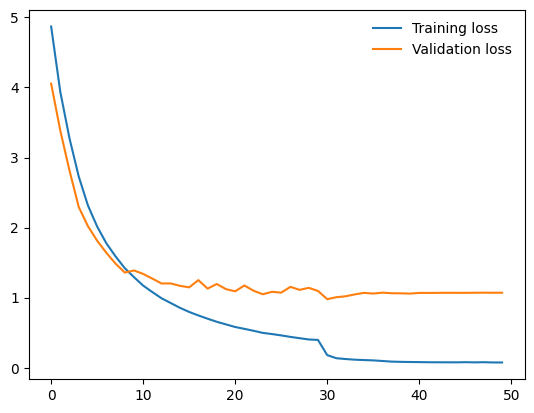

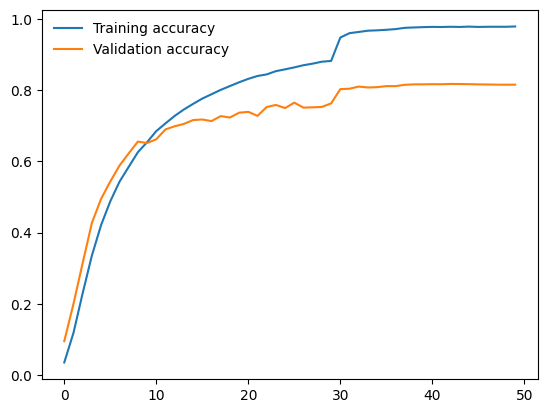

In [8]:
#train the model
train_losses, train_acc, val_losses, val_acc = train(model, train_loader, val_loader, criterion, optimizer, scheduler, hyper_params = prms, verbose = 2, test_transform = train_transform, experiment=prms["experiment"])

#plot the training and validation metrics
plot_metrics(train_losses, train_acc, val_losses, val_acc)

In [9]:
#test the model
test(model, test_loader, criterion, hyper_params = prms, experiment = prms["experiment"])

RuntimeError: Error(s) in loading state_dict for GhostNet:
	Missing key(s) in state_dict: "features.1.conv.2.fc.0.weight", "features.1.conv.2.fc.0.bias", "features.1.conv.2.fc.2.weight", "features.1.conv.2.fc.2.bias", "features.4.conv.2.fc.0.weight", "features.4.conv.2.fc.0.bias", "features.4.conv.2.fc.2.weight", "features.4.conv.2.fc.2.bias", "features.5.conv.1.fc.0.weight", "features.5.conv.1.fc.0.bias", "features.5.conv.1.fc.2.weight", "features.5.conv.1.fc.2.bias", "features.6.conv.1.fc.0.weight", "features.6.conv.1.fc.0.bias", "features.6.conv.1.fc.2.weight", "features.6.conv.1.fc.2.bias", "features.7.conv.1.fc.0.weight", "features.7.conv.1.fc.0.bias", "features.7.conv.1.fc.2.weight", "features.7.conv.1.fc.2.bias", "features.8.conv.1.fc.0.weight", "features.8.conv.1.fc.0.bias", "features.8.conv.1.fc.2.weight", "features.8.conv.1.fc.2.bias", "features.9.conv.2.fc.0.weight", "features.9.conv.2.fc.0.bias", "features.9.conv.2.fc.2.weight", "features.9.conv.2.fc.2.bias", "features.10.conv.1.fc.0.weight", "features.10.conv.1.fc.0.bias", "features.10.conv.1.fc.2.weight", "features.10.conv.1.fc.2.bias", "features.11.conv.1.fc.0.weight", "features.11.conv.1.fc.0.bias", "features.11.conv.1.fc.2.weight", "features.11.conv.1.fc.2.bias". 
	Unexpected key(s) in state_dict: "features.1.conv.2.ca.total_ops", "features.1.conv.2.ca.total_params", "features.1.conv.2.ca.sharedMLP.0.weight", "features.1.conv.2.ca.sharedMLP.2.weight", "features.1.conv.2.ca.sigmoid.total_ops", "features.1.conv.2.ca.sigmoid.total_params", "features.1.conv.2.sa.total_ops", "features.1.conv.2.sa.total_params", "features.1.conv.2.sa.conv.weight", "features.1.conv.2.sa.sigmoid.total_ops", "features.1.conv.2.sa.sigmoid.total_params", "features.4.conv.2.ca.total_ops", "features.4.conv.2.ca.total_params", "features.4.conv.2.ca.sharedMLP.0.weight", "features.4.conv.2.ca.sharedMLP.2.weight", "features.4.conv.2.ca.sigmoid.total_ops", "features.4.conv.2.ca.sigmoid.total_params", "features.4.conv.2.sa.total_ops", "features.4.conv.2.sa.total_params", "features.4.conv.2.sa.conv.weight", "features.4.conv.2.sa.sigmoid.total_ops", "features.4.conv.2.sa.sigmoid.total_params", "features.5.conv.1.ca.total_ops", "features.5.conv.1.ca.total_params", "features.5.conv.1.ca.sharedMLP.0.weight", "features.5.conv.1.ca.sharedMLP.2.weight", "features.5.conv.1.ca.sigmoid.total_ops", "features.5.conv.1.ca.sigmoid.total_params", "features.5.conv.1.sa.total_ops", "features.5.conv.1.sa.total_params", "features.5.conv.1.sa.conv.weight", "features.5.conv.1.sa.sigmoid.total_ops", "features.5.conv.1.sa.sigmoid.total_params", "features.6.conv.1.ca.total_ops", "features.6.conv.1.ca.total_params", "features.6.conv.1.ca.sharedMLP.0.weight", "features.6.conv.1.ca.sharedMLP.2.weight", "features.6.conv.1.ca.sigmoid.total_ops", "features.6.conv.1.ca.sigmoid.total_params", "features.6.conv.1.sa.total_ops", "features.6.conv.1.sa.total_params", "features.6.conv.1.sa.conv.weight", "features.6.conv.1.sa.sigmoid.total_ops", "features.6.conv.1.sa.sigmoid.total_params", "features.7.conv.1.ca.total_ops", "features.7.conv.1.ca.total_params", "features.7.conv.1.ca.sharedMLP.0.weight", "features.7.conv.1.ca.sharedMLP.2.weight", "features.7.conv.1.ca.sigmoid.total_ops", "features.7.conv.1.ca.sigmoid.total_params", "features.7.conv.1.sa.total_ops", "features.7.conv.1.sa.total_params", "features.7.conv.1.sa.conv.weight", "features.7.conv.1.sa.sigmoid.total_ops", "features.7.conv.1.sa.sigmoid.total_params", "features.8.conv.1.ca.total_ops", "features.8.conv.1.ca.total_params", "features.8.conv.1.ca.sharedMLP.0.weight", "features.8.conv.1.ca.sharedMLP.2.weight", "features.8.conv.1.ca.sigmoid.total_ops", "features.8.conv.1.ca.sigmoid.total_params", "features.8.conv.1.sa.total_ops", "features.8.conv.1.sa.total_params", "features.8.conv.1.sa.conv.weight", "features.8.conv.1.sa.sigmoid.total_ops", "features.8.conv.1.sa.sigmoid.total_params", "features.9.conv.2.ca.total_ops", "features.9.conv.2.ca.total_params", "features.9.conv.2.ca.sharedMLP.0.weight", "features.9.conv.2.ca.sharedMLP.2.weight", "features.9.conv.2.ca.sigmoid.total_ops", "features.9.conv.2.ca.sigmoid.total_params", "features.9.conv.2.sa.total_ops", "features.9.conv.2.sa.total_params", "features.9.conv.2.sa.conv.weight", "features.9.conv.2.sa.sigmoid.total_ops", "features.9.conv.2.sa.sigmoid.total_params", "features.10.conv.1.ca.total_ops", "features.10.conv.1.ca.total_params", "features.10.conv.1.ca.sharedMLP.0.weight", "features.10.conv.1.ca.sharedMLP.2.weight", "features.10.conv.1.ca.sigmoid.total_ops", "features.10.conv.1.ca.sigmoid.total_params", "features.10.conv.1.sa.total_ops", "features.10.conv.1.sa.total_params", "features.10.conv.1.sa.conv.weight", "features.10.conv.1.sa.sigmoid.total_ops", "features.10.conv.1.sa.sigmoid.total_params", "features.11.conv.1.ca.total_ops", "features.11.conv.1.ca.total_params", "features.11.conv.1.ca.sharedMLP.0.weight", "features.11.conv.1.ca.sharedMLP.2.weight", "features.11.conv.1.ca.sigmoid.total_ops", "features.11.conv.1.ca.sigmoid.total_params", "features.11.conv.1.sa.total_ops", "features.11.conv.1.sa.total_params", "features.11.conv.1.sa.conv.weight", "features.11.conv.1.sa.sigmoid.total_ops", "features.11.conv.1.sa.sigmoid.total_params". 